<a href="https://colab.research.google.com/github/Hamid-Mofidi/PINNs_on_Multiple_timescale_dynamics/blob/main/Examples/Example2_3x3exact_sol_PINNs_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

from scipy.integrate import odeint

# Define the ODE system
def Fast_sub_system(y, t, eps):
    x, y, z = y
    dxdt = -x
    dydt = 2 * y
    dzdt = 0
    return [dxdt, dydt, dzdt]

def Slow_sub_system(y, tau, eps):
    x, y, z = y
    dzdtau = x**2 + 1
    return [dzdtau]

# Define the exact solution
def Fast_solution(t, eps, x0, y0, z0):
    x_real_fast = x0 * np.exp(-t)
    y_real_fast = y0 * np.exp(2 * t)
    z_real_fast = z0 * t
    return x_real_fast, y_real_fast, z_real_fast

def Slow_solution(tau, eps, x1, y1, z1):
    x_real_slow = 0 * tau
    y_real_slow = 0 * tau
    z_real_slow = tau + z1
    return x_real_slow, y_real_slow, z_real_slow

# Initial conditions
x0 = 1
y0 = 0
z0 = 0
t_end = 10
t  =  np.linspace(0, t_end, 100)
tau = np.linspace(0, 0.1, 100)
eps = 0.01

# Exact solution
x_exact_fast, y_exact_fast, z_exact_fast = Fast_solution(t, eps, x0, y0, z0)

# Get the final state of the fast system
x1, y1, z1 = x_exact_fast[-1], y_exact_fast[-1], z_exact_fast[-1]

print([x1,y1,z1])

# Exact solution for the slow system using the final state of the fast system as initial conditions
x_exact_slow, y_exact_slow, z_exact_slow = Slow_solution(tau, eps, x1, y1, z1)

# Transform to tensor
t_tensor = torch.tensor(t.reshape(-1, 1), dtype=torch.float32)
x_real_fast_tensor = torch.tensor(x_exact_fast.reshape(-1, 1), dtype=torch.float32)
y_real_fast_tensor = torch.tensor(y_exact_fast.reshape(-1, 1), dtype=torch.float32)
z_real_fast_tensor = torch.tensor(z_exact_fast.reshape(-1, 1), dtype=torch.float32)

tau_tensor = torch.tensor(tau.reshape(-1, 1), dtype=torch.float32)
x_real_slow_tensor = torch.tensor(x_exact_slow.reshape(-1, 1), dtype=torch.float32)
y_real_slow_tensor = torch.tensor(y_exact_slow.reshape(-1, 1), dtype=torch.float32)
z_real_slow_tensor = torch.tensor(z_exact_slow.reshape(-1, 1), dtype=torch.float32)

def input_transform(t_tensor):
    return torch.cat([t_tensor], dim=1)

class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.fc1 = nn.Linear(1, 300)
        self.fc2 = nn.Linear(300, 300)
        self.fc3 = nn.Linear(300, 3)

    def forward(self, t):
        t = input_transform(t)
        x = torch.tanh(self.fc1(t))
        x = torch.tanh(self.fc2(x))
        x = self.fc3(x)
        return x

def loss_func_fast(model, t_tensor, x_exact_fast, y_exact_fast, z_exact_fast, x0, y0, z0, x_T, y_T, z_T, eps, random_points=10):
    t_tensor.requires_grad = True
    pred_fast = model(t_tensor)
    x_pred_fast, y_pred_fast, z_pred_fast = pred_fast[:, 0].unsqueeze(1), pred_fast[:, 1].unsqueeze(1), pred_fast[:, 2].unsqueeze(1)

    dx_dt = torch.autograd.grad(x_pred_fast.sum(), t_tensor, retain_graph=True, create_graph=True)[0]
    dy_dt = torch.autograd.grad(y_pred_fast.sum(), t_tensor, retain_graph=True, create_graph=True)[0]
    dz_dt = torch.autograd.grad(z_pred_fast.sum(), t_tensor, retain_graph=True, create_graph=True)[0]

    residual1_fast = dx_dt + x_pred_fast
    residual2_fast = dy_dt - 2 * y_pred_fast
    residual3_fast = dz_dt
    init_loss_fast = torch.square(x_pred_fast[0] - x0) + torch.square(y_pred_fast[0] - y0) + torch.square(z_pred_fast[0] - z0)
    physics_loss_fast = torch.mean(residual1_fast**2 + residual2_fast**2 + residual3_fast**2)

    random_indices = torch.randint(0, x_exact_fast.shape[0], (random_points,))
    data_loss_fast = torch.mean((x_pred_fast[random_indices] - x_exact_fast[random_indices])**2 +
                           (y_pred_fast[random_indices] - y_exact_fast[random_indices])**2 +
                           (z_pred_fast[random_indices] - z_exact_fast[random_indices])**2
                          )

    boundary_loss_fast = torch.square(x_pred_fast[-1] - x_T) + torch.square(y_pred_fast[-1] - y_T) + torch.square(z_pred_fast[-1] - z_T)

    total_loss_fast = physics_loss_fast + 10*init_loss_fast + 10*boundary_loss_fast + 10*data_loss_fast

    return total_loss_fast

def loss_func_slow(model, tau_tensor, x_exact_slow, y_exact_slow, z_exact_slow, x1, y1, z1, x_TT, y_TT, z_TT, eps, random_points=10):
    tau_tensor.requires_grad = True
    pred_slow = model(tau_tensor)
    x_pred_slow, y_pred_slow, z_pred_slow = pred_slow[:, 0].unsqueeze(1), pred_slow[:, 1].unsqueeze(1), pred_slow[:, 2].unsqueeze(1)

    dx_dtau = torch.autograd.grad(x_pred_slow.sum(), tau_tensor, retain_graph=True, create_graph=True)[0]
    dy_dtau = torch.autograd.grad(y_pred_slow.sum(), tau_tensor, retain_graph=True, create_graph=True)[0]
    dz_dtau = torch.autograd.grad(z_pred_slow.sum(), tau_tensor, retain_graph=True, create_graph=True)[0]

    residual1_slow = 0  # dx_dtau + x_pred_slow / eps
    residual2_slow = 0  # dy_dtau - (2 * y_pred_slow + eps * x_pred_slow) / eps
    residual3_slow = dz_dtau - x_pred_slow**2 - 1
    init_loss_slow = torch.square(x_pred_slow[0] - x1) + torch.square(y_pred_slow[0] - y1) + torch.square(z_pred_slow[0] - z1)
    physics_loss_slow = torch.mean(residual1_slow**2 + residual2_slow**2 + residual3_slow**2)

    random_indices = torch.randint(0, x_exact_slow.shape[0], (random_points,))
    data_loss_slow = torch.mean((x_pred_slow[random_indices] - x_exact_slow[random_indices])**2 +
                           (y_pred_slow[random_indices] - y_exact_slow[random_indices])**2 +
                           (z_pred_slow[random_indices] - z_exact_slow[random_indices])**2
                          )

    boundary_loss_slow = torch.square(x_pred_slow[-1] - x_TT) + torch.square(y_pred_slow[-1] - y_TT) + torch.square(z_pred_slow[-1] - z_TT)

    total_loss_slow = physics_loss_slow + 10 * init_loss_slow + 10 * boundary_loss_slow + 10 * data_loss_slow

    return total_loss_slow


if __name__=='__main__':
    model_fast = PINN()
    optimizer_fast = torch.optim.Adam(model_fast.parameters(), lr=1e-3)
    loss_values_fast = []
    epoch_num = 20000

    # Train the model for the fast subsystem
    for epoch in range(epoch_num):
        loss_fast = loss_func_fast(model_fast, t_tensor, x_real_fast_tensor, y_real_fast_tensor, z_real_fast_tensor, x0, y0, z0, x_exact_fast[-1], y_exact_fast[-1], z_exact_fast[-1], eps, random_points=10)
        optimizer_fast.zero_grad()
        loss_fast.backward()
        optimizer_fast.step()
        if epoch % 1000 == 0:
            print(f'Epoch {epoch}, Loss: {loss_fast.item()}')
        loss_values_fast.append(loss_fast.item())

    # Separate model for the slow subsystem
    model_slow = PINN()
    optimizer_slow = torch.optim.Adam(model_slow.parameters(), lr=1e-3)
    loss_values_slow = []

    # Train the model for the slow subsystem
    for epoch in range(epoch_num):
        loss_slow = loss_func_slow(model_slow, tau_tensor, x_real_slow_tensor, y_real_slow_tensor, z_real_slow_tensor, x1, y1, z1, x_exact_slow[-1], y_exact_slow[-1], z_exact_slow[-1], eps, random_points=10)
        optimizer_slow.zero_grad()
        loss_slow.backward()
        optimizer_slow.step()
        if epoch % 1000 == 0:
            print(f'Epoch {epoch}, Loss: {loss_slow.item()}')
        loss_values_slow.append(loss_slow.item())


[4.5399929762484854e-05, 0.0, 0.0]
Epoch 0, Loss: 11.78188705444336
Epoch 1000, Loss: 0.0007014994625933468
Epoch 2000, Loss: 0.00023520964896306396
Epoch 3000, Loss: 0.00020690418023150414
Epoch 4000, Loss: 0.004139670170843601
Epoch 5000, Loss: 0.002354612573981285
Epoch 6000, Loss: 0.0007452896097674966
Epoch 7000, Loss: 0.0019991325680166483
Epoch 8000, Loss: 3.651528822956607e-05
Epoch 9000, Loss: 3.950562313548289e-05
Epoch 10000, Loss: 0.0002522369031794369
Epoch 11000, Loss: 2.2407877622754313e-05
Epoch 12000, Loss: 0.002452706918120384
Epoch 13000, Loss: 2.188984763051849e-05
Epoch 14000, Loss: 2.1498479327419773e-05
Epoch 15000, Loss: 5.853485708939843e-05
Epoch 16000, Loss: 0.0008376085897907615
Epoch 17000, Loss: 0.0025315594393759966
Epoch 18000, Loss: 0.0001592395710758865
Epoch 19000, Loss: 3.5978206142317504e-05
Epoch 0, Loss: 2.891127586364746
Epoch 1000, Loss: 1.2735245945805218e-05
Epoch 2000, Loss: 1.1403244570828974e-06
Epoch 3000, Loss: 9.977053559850901e-05
Epoch

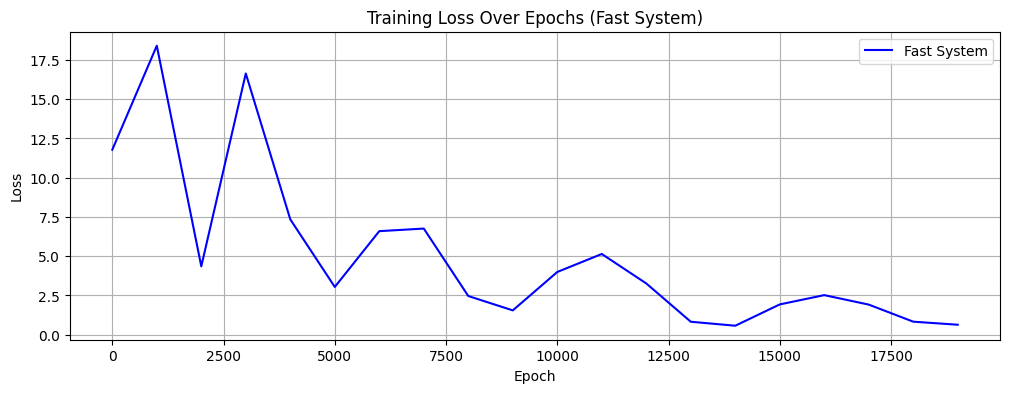

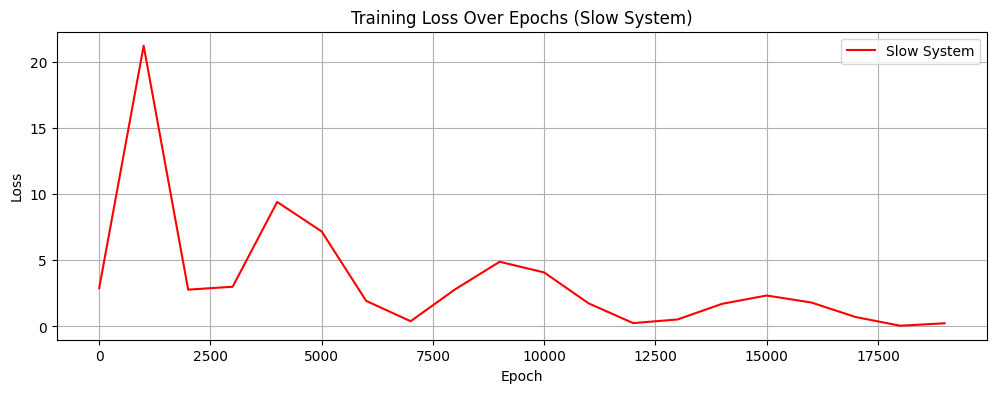

In [ ]:
import matplotlib.pyplot as plt

# Plotting training loss over epochs
plt.figure(figsize=(12, 4))
plt.plot(range(0, epoch_num, 1000), loss_values_fast[:epoch_num//1000], 'b', label='Fast System')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs (Fast System)')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 4))
plt.plot(range(0, epoch_num, 1000), loss_values_slow[:epoch_num//1000], 'r', label='Slow System')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs (Slow System)')
plt.legend()
plt.grid(True)
plt.show()

# Model evaluation
model.eval()
with torch.no_grad():
    # Predictions for fast system
    x_pred_fast, y_pred_fast, z_pred_fast = model(t_tensor).numpy().T

    # Predictions for slow system
    x_pred_slow, y_pred_slow, z_pred_slow = model(tau_tensor).numpy().T


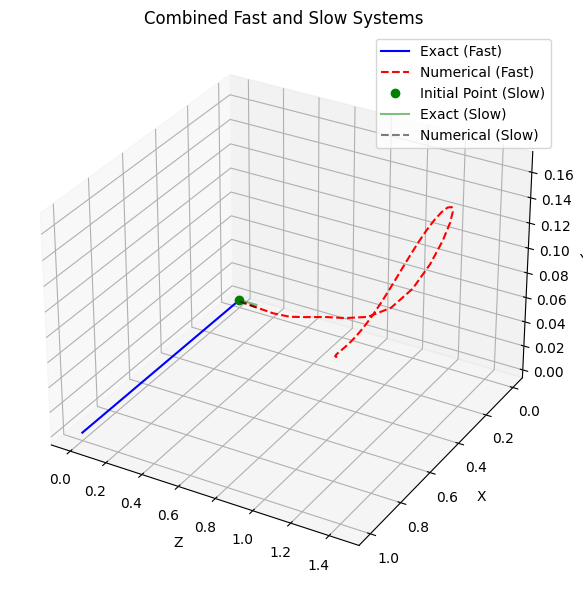

In [ ]:
# Plotting the 3D trajectories
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111, projection='3d')

# Plotting fast system
ax.plot(z_exact_fast, x_exact_fast, y_exact_fast, 'b-', label='Exact (Fast)')
ax.plot(z_pred_fast, x_pred_fast, y_pred_fast, 'r--', label='Numerical (Fast)')

# Plotting slow system initial point
ax.plot([z_exact_fast[-1]], [x_exact_fast[-1]], [y_exact_fast[-1]], 'go', label='Initial Point (Slow)')

# Plotting slow system continuation
ax.plot(z_exact_slow + z_exact_fast[-1], x_exact_slow + x_exact_fast[-1], y_exact_slow + y_exact_fast[-1], 'g-', label='Exact (Slow)', alpha=0.5)
ax.plot(z_pred_slow + z_exact_fast[-1], x_pred_slow + x_exact_fast[-1], y_pred_slow + x_exact_fast[-1], 'k--', label='Numerical (Slow)', alpha=0.5)

ax.set_xlabel('Z')
ax.set_ylabel('X')
ax.set_zlabel('Y')
ax.set_title('Combined Fast and Slow Systems')
ax.legend()
ax.invert_yaxis()

plt.tight_layout()
plt.show()
